# imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import phik 
from phik.report import plot_correlation_matrix
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, make_scorer
import optuna
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models as vision_models
import torch.optim as optim
import torchvision
import torchvision.transforms as tt
from PIL import Image
import random
from pathlib import Path
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

tqdm.pandas()

# Зафиксируем сиды, чтобы обучение было воспроизводимым.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1001)

import warnings
warnings.filterwarnings("ignore")

# data loading

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,did_not_apologize,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing,gift_receiving
0,269178,5.22,Девочка,22,3.0,23,2.0,1965.0,3.0,36.0,12.0,Превосходно,Активный участник,Лентяй,91.0,59.0,"Проявил доброту, помогая близким — это похвально!",NaN,DZWF0J76ET.jpg,1
1,269179,9.47,Мальчик,5,7.0,21,4.0,1936.0,3.0,35.0,5.0,Хорошо,Активный участник,Часто откладывает,40.0,34.0,NaN,Уважаемый Дедушка Мороз! \nУ меня в школе все ...,7OTWCDNQ23.jpg,1
2,269180,6.35,Девочка,10,6.0,16,4.0,1668.0,8.0,37.0,20.0,Ниже среднего,Непостоянный энтузиаст,Лентяй,92.0,4.0,NaN,NaN,NKXZH0G2UQ.jpg,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person             8000 non-null   int64  
 1   age_num            8000 non-null   float64
 2   sex                8000 non-null   object 
 3   household_chores   8000 non-null   int64  
 4   shared_things      8000 non-null   float64
 5   good_deeds         8000 non-null   int64  
 6   quarreled          8000 non-null   float64
 7   lied               8000 non-null   float64
 8   skiped_lessons     8000 non-null   float64
 9   acted_badly        8000 non-null   float64
 10  did_not_apologize  8000 non-null   float64
 11  school_results     8000 non-null   object 
 12  activity_level     8000 non-null   object 
 13  lazy_level         8000 non-null   object 
 14  creative_ways      8000 non-null   float64
 15  curiosity_level    8000 non-null   float64
 16  comments           3219 

In [4]:
pred_df = pd.read_csv('test.csv')
pred_df.head(3)

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,did_not_apologize,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing
0,277178,9.61,Девочка,20,6.0,23,4.0,1165.0,6.0,30.0,13.0,Отлично,Редкий гость,Редко откладывает,59.0,56.0,NaN,NaN,B2VANIROYC.jpg
1,277179,12.33,Девочка,20,6.0,22,2.0,1762.0,1.0,49.0,17.0,Отлично,Редкий гость,Средний уровень,81.0,54.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я нич...",X10WFLD6Z8.jpg
2,277180,7.20,Мальчик,22,1.0,13,4.0,478.0,4.0,71.0,5.0,Отлично,Непостоянный энтузиаст,Средний уровень,6.0,14.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я был...",J1YN5FZBXK.jpg


In [5]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   person             2000 non-null   int64  
 1   age_num            2000 non-null   float64
 2   sex                2000 non-null   object 
 3   household_chores   2000 non-null   int64  
 4   shared_things      2000 non-null   float64
 5   good_deeds         2000 non-null   int64  
 6   quarreled          2000 non-null   float64
 7   lied               2000 non-null   float64
 8   skiped_lessons     2000 non-null   float64
 9   acted_badly        2000 non-null   float64
 10  did_not_apologize  2000 non-null   float64
 11  school_results     2000 non-null   object 
 12  activity_level     2000 non-null   object 
 13  lazy_level         2000 non-null   object 
 14  creative_ways      2000 non-null   float64
 15  curiosity_level    2000 non-null   float64
 16  comments           816 n

# num_rays

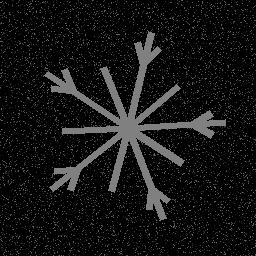

In [8]:
Image.open('images/'+df['drawing'][0]).convert("RGB")

In [26]:
import cv2
import numpy as np

def count_rays(image_path):
    """
    Определяет количество лучей у снежинки на изображении.

    Args:
        image_path: Путь к изображению снежинки.

    Returns:
        Количество лучей (int) или None, если не удалось определить.
    """
    try:
        # Загружаем изображение в оттенках серого
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Применяем пороговое преобразование, чтобы отделить снежинку от фона
        _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

        # Находим контуры на изображении
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Находим самый большой контур (предполагаем, что это снежинка)
        if not contours:
            print("Контуры не найдены.")
            return None
        cnt = max(contours, key=cv2.contourArea)

        # Аппроксимируем контур многоугольником
        epsilon = 0.01 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        # Количество вершин многоугольника примерно равно количеству лучей
        # (может потребоваться корректировка в зависимости от формы снежинки)
        # В данном случае, учитывая форму представленной снежинки,
        # количество лучей равно количеству вершин, деленному на 2, так как каждая вершина - это либо начало луча, либо конец разветвления.
        # Если бы разветвлений не было, то количество лучей было бы равно количеству вершин.
        num_rays = len(approx) // 2

        # Если количество вершин нечетное, то скорее всего это из-за шума или неточности аппроксимации.
        # В таком случае можно округлить количество лучей до ближайшего четного числа.
        # Но в данном случае, из-за особенностей формы, это не требуется.

        return num_rays

    except Exception as e:
        print(f"Произошла ошибка: {e}")
        return None

# Пример использования
image_path = 'images/'+df['drawing'][0]  # Замените на путь к вашему изображению
num_rays = count_rays(image_path)

if num_rays is not None:
    print(f"Количество лучей: {num_rays}")

Количество лучей: 5


In [35]:
lst=[]

for i in tqdm(range(len(df))):
    if str(df['drawing'][i]) != 'nan':
        num_rays = count_rays('images/'+df['drawing'][i])
        lst.append(num_rays)
    else: lst.append(np.nan)
    
df['num_rays'] = lst
df

  0%|          | 0/8000 [00:00<?, ?it/s]

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,...,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing,gift_receiving,num_rays
0,269178,5.22,Девочка,22,3.0,23,2.0,1965.0,3.0,36.0,...,Превосходно,Активный участник,Лентяй,91.0,59.0,"Проявил доброту, помогая близким — это похвально!",NaN,DZWF0J76ET.jpg,1,5.0
1,269179,9.47,Мальчик,5,7.0,21,4.0,1936.0,3.0,35.0,...,Хорошо,Активный участник,Часто откладывает,40.0,34.0,NaN,Уважаемый Дедушка Мороз! \nУ меня в школе все ...,7OTWCDNQ23.jpg,1,5.0
2,269180,6.35,Девочка,10,6.0,16,4.0,1668.0,8.0,37.0,...,Ниже среднего,Непостоянный энтузиаст,Лентяй,92.0,4.0,NaN,NaN,NKXZH0G2UQ.jpg,1,5.0
3,269181,8.04,Мальчик,42,1.0,28,3.0,1761.0,1.0,58.0,...,Удовлетворительно,Созерцатель,Лентяй,69.0,31.0,Помог бабушке перейти дорогу — это очень благо...,"Дедушка! \nПишет тебе Ростислав, мне 8 лет. \n...",HZMS5QEV6I.jpg,1,8.0
4,269182,7.38,Мальчик,53,10.0,7,2.0,794.0,8.0,96.0,...,Превосходно,Созерцатель,Часто откладывает,35.0,97.0,Иногда не может сдержать свои эмоции во время ...,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,277173,8.37,Мальчик,39,10.0,24,3.0,18.0,4.0,24.0,...,Отлично,Непостоянный энтузиаст,Часто откладывает,63.0,55.0,NaN,"Дед! \nЯ рад, что наступила зима и твой праздн...",5MP6CBA0EZ.jpg,1,6.0
7996,277174,9.78,Мальчик,19,9.0,13,4.0,518.0,3.0,79.0,...,Превосходно,Редкий гость,Средний уровень,43.0,14.0,NaN,"Дорогой Санта! \nПишет тебе Юлиан, мне 9 лет. ...",43S87DMIJ1.jpg,0,5.0
7997,277175,11.69,Мальчик,15,3.0,19,4.0,1703.0,6.0,82.0,...,Выше среднего,Непостоянный энтузиаст,Средний уровень,48.0,33.0,"Было замечено, что пропустил важный урок без п...","Здравствуйте, Дедушка. \nПишет тебе Альберт, м...",NC5TXB2S4M.jpg,0,5.0
7998,277176,6.27,Девочка,10,0.0,32,0.0,943.0,3.0,71.0,...,Ниже среднего,Редкий гость,Редко откладывает,68.0,1.0,NaN,NaN,PEOI3JGH5C.jpg,1,5.0


# image clustering

In [6]:
img_df = df[['drawing']]
img_df.dropna(inplace=True)
img_df

,drawing
0,DZWF0J76ET.jpg
1,7OTWCDNQ23.jpg
2,NKXZH0G2UQ.jpg
3,HZMS5QEV6I.jpg
5,1XUW8LYPNS.jpg
...,...
7995,5MP6CBA0EZ.jpg
7996,43S87DMIJ1.jpg
7997,NC5TXB2S4M.jpg
7998,PEOI3JGH5C.jpg


In [7]:
image_path = 'images'

# Создание новой колонки 'images' с numpy-массивами изображений
def read_image(filename):
    try:
        img = Image.open(os.path.join(image_path, filename))
        # Преобразование изображения в RGB (если оно не в RGB) и в numpy-массив
        img = img.convert('RGB')
        return np.array(img)
    except Exception as e:
        print(f"Ошибка при чтении файла {filename}: {e}")
        return None

In [ ]:
img_df['images'] = img_df['drawing'].progress_apply(read_image)

complete


In [9]:
pca = PCA(n_components=100)
images = np.array([img.flatten() for img in tqdm(img_df['images'])])
# images = pca.fit_transform(np.array([img.flatten() for img in img_df['images']]))

  0%|          | 0/7374 [00:00<?, ?it/s]

In [10]:
kmeans = KMeans(n_clusters=5, random_state=1001)
kmeans.fit(images)

KMeans(n_clusters=5, random_state=1001)

In [11]:
img_df['cluster'] = kmeans.labels_
img_df.drop(columns=['images'], inplace=True)
img_df

,drawing,cluster
0,DZWF0J76ET.jpg,2
1,7OTWCDNQ23.jpg,3
2,NKXZH0G2UQ.jpg,2
3,HZMS5QEV6I.jpg,2
5,1XUW8LYPNS.jpg,3
...,...,...
7995,5MP6CBA0EZ.jpg,4
7996,43S87DMIJ1.jpg,2
7997,NC5TXB2S4M.jpg,3
7998,PEOI3JGH5C.jpg,0


In [12]:
Counter(img_df.cluster)

Counter({3: 2397, 2: 2381, 4: 1412, 0: 701, 1: 483})

In [13]:
df = pd.merge(df, img_df, on='drawing', how='left')
df

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,...,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing,gift_receiving,cluster
0,269178,5.22,Девочка,22,3.0,23,2.0,1965.0,3.0,36.0,...,Превосходно,Активный участник,Лентяй,91.0,59.0,"Проявил доброту, помогая близким — это похвально!",NaN,DZWF0J76ET.jpg,1,2.0
1,269179,9.47,Мальчик,5,7.0,21,4.0,1936.0,3.0,35.0,...,Хорошо,Активный участник,Часто откладывает,40.0,34.0,NaN,Уважаемый Дедушка Мороз! \nУ меня в школе все ...,7OTWCDNQ23.jpg,1,3.0
2,269180,6.35,Девочка,10,6.0,16,4.0,1668.0,8.0,37.0,...,Ниже среднего,Непостоянный энтузиаст,Лентяй,92.0,4.0,NaN,NaN,NKXZH0G2UQ.jpg,1,2.0
3,269181,8.04,Мальчик,42,1.0,28,3.0,1761.0,1.0,58.0,...,Удовлетворительно,Созерцатель,Лентяй,69.0,31.0,Помог бабушке перейти дорогу — это очень благо...,"Дедушка! \nПишет тебе Ростислав, мне 8 лет. \n...",HZMS5QEV6I.jpg,1,2.0
4,269182,7.38,Мальчик,53,10.0,7,2.0,794.0,8.0,96.0,...,Превосходно,Созерцатель,Часто откладывает,35.0,97.0,Иногда не может сдержать свои эмоции во время ...,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,277173,8.37,Мальчик,39,10.0,24,3.0,18.0,4.0,24.0,...,Отлично,Непостоянный энтузиаст,Часто откладывает,63.0,55.0,NaN,"Дед! \nЯ рад, что наступила зима и твой праздн...",5MP6CBA0EZ.jpg,1,4.0
7996,277174,9.78,Мальчик,19,9.0,13,4.0,518.0,3.0,79.0,...,Превосходно,Редкий гость,Средний уровень,43.0,14.0,NaN,"Дорогой Санта! \nПишет тебе Юлиан, мне 9 лет. ...",43S87DMIJ1.jpg,0,2.0
7997,277175,11.69,Мальчик,15,3.0,19,4.0,1703.0,6.0,82.0,...,Выше среднего,Непостоянный энтузиаст,Средний уровень,48.0,33.0,"Было замечено, что пропустил важный урок без п...","Здравствуйте, Дедушка. \nПишет тебе Альберт, м...",NC5TXB2S4M.jpg,0,3.0
7998,277176,6.27,Девочка,10,0.0,32,0.0,943.0,3.0,71.0,...,Ниже среднего,Редкий гость,Редко откладывает,68.0,1.0,NaN,NaN,PEOI3JGH5C.jpg,1,0.0


In [14]:
del img_df

# data preprocessing

In [6]:
len(df.columns)

20

In [29]:
# feature engineering
df['new_let'] = df['letter'].notnull().astype(int) 

# df['new_com'] = df['comments'].notnull().astype(int) херня

age_cluster = KMeans(n_clusters=3, random_state=1001)
df['age_cluster'] = age_cluster.fit_predict(np.array(df['age_num']).reshape(-1, 1))

df

,person,age_num,household_chores,shared_things,quarreled,acted_badly,did_not_apologize,school_results,lazy_level,creative_ways,curiosity_level,letter,gift_receiving,new_let,age_cluster
0,269178,5.22,22,3.0,2.0,36.0,12.0,4,0,91.0,59.0,,1,1,0
1,269179,9.47,5,7.0,4.0,35.0,5.0,6,4,40.0,34.0,Уважаемый Дедушка Мороз! \nУ меня в школе все ...,1,1,2
2,269180,6.35,10,6.0,4.0,37.0,20.0,2,0,92.0,4.0,,1,1,0
3,269181,8.04,42,1.0,3.0,58.0,16.0,5,0,69.0,31.0,"Дедушка! \nПишет тебе Ростислав, мне 8 лет. \n...",1,1,3
4,269182,7.38,53,10.0,2.0,96.0,7.0,4,4,35.0,97.0,,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,277173,8.37,39,10.0,3.0,24.0,6.0,3,4,63.0,55.0,"Дед! \nЯ рад, что наступила зима и твой праздн...",1,1,3
7996,277174,9.78,19,9.0,4.0,79.0,8.0,4,2,43.0,14.0,"Дорогой Санта! \nПишет тебе Юлиан, мне 9 лет. ...",0,1,2
7997,277175,11.69,15,3.0,4.0,82.0,14.0,0,2,48.0,33.0,"Здравствуйте, Дедушка. \nПишет тебе Альберт, м...",0,1,1
7998,277176,6.27,10,0.0,0.0,71.0,14.0,2,1,68.0,1.0,,1,1,0


In [19]:
df.drop(columns=['drawing'], inplace=True)
df['letter'].fillna('', inplace=True)
# df['comments'].fillna('', inplace=True)
df.isna().sum()

person                  0
age_num                 0
sex                     0
household_chores        0
shared_things           0
good_deeds              0
quarreled               0
lied                    0
skiped_lessons          0
acted_badly             0
did_not_apologize       0
school_results          0
activity_level          0
lazy_level              0
creative_ways           0
curiosity_level         0
comments             4781
letter                  0
gift_receiving          0
new_let                 0
age_cluster             0
dtype: int64

In [20]:
len(df.columns)

21

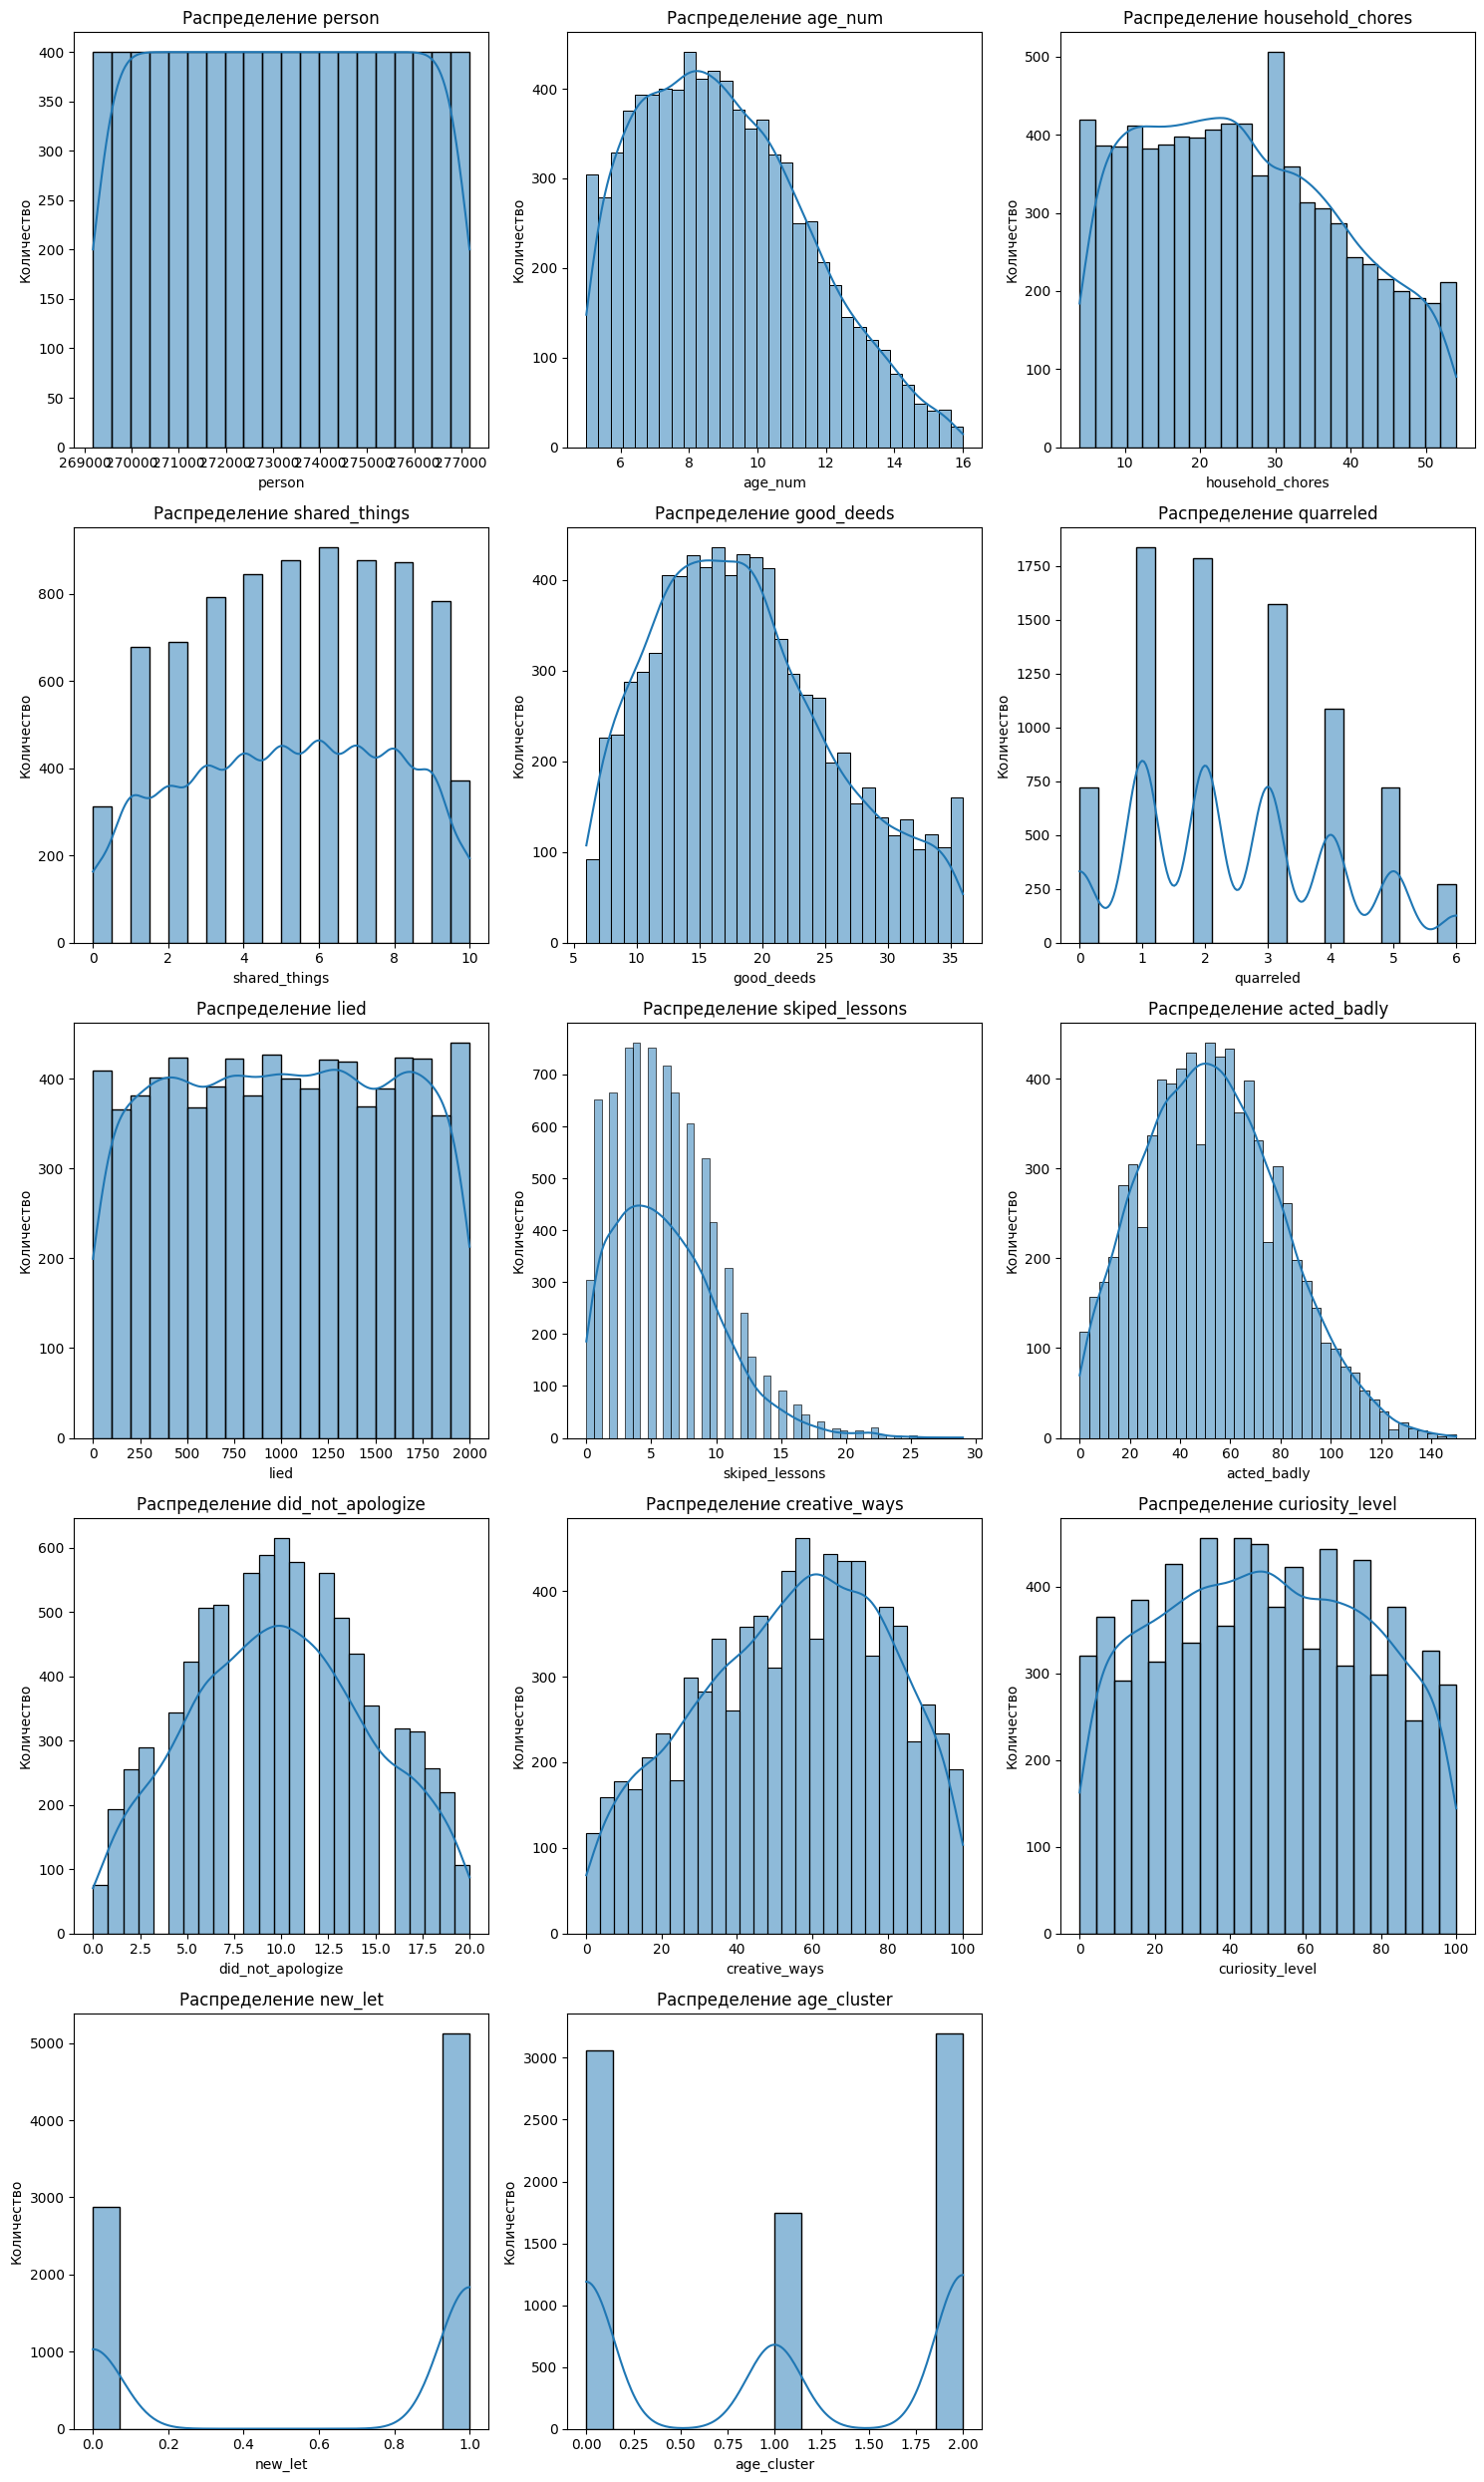

In [21]:
# визуализация распределения признаков
def visualize_distributions(df, numeric_only=True):
    """
    Визуализирует распределение признаков в DataFrame.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        numeric_only (bool, optional): Визуализировать только числовые признаки. По умолчанию True.
    """

    if numeric_only:
        numeric_cols = df.select_dtypes(include=['number']).columns
    else:
        numeric_cols = df.columns
    
    if len(numeric_cols) == 0:
      print("Нет числовых признаков для визуализации.")
      return
    
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 2) // 3  # Определяем количество строк для подграфиков

    plt.figure(figsize=(15, 5 * num_rows)) # Делаем размеры рисунка побольше

    for i, column in enumerate(numeric_cols, 1):
        plt.subplot(num_rows, 3, i) # Создаем подграфик на каждой итерации
        sns.histplot(df[column], kde=True)  # Гистограмма с KDE (оценка плотности ядра)
        plt.title(f'Распределение {column}') # Выводим заголовок к графику
        plt.xlabel(column) # Выводим название оси Х
        plt.ylabel("Количество") # Выводим название оси Y

    plt.tight_layout()  # Автоматически регулирует расположение графиков
    plt.show()


# Визуализируем распределения числовых признаков
visualize_distributions(df.drop(columns=['gift_receiving']))

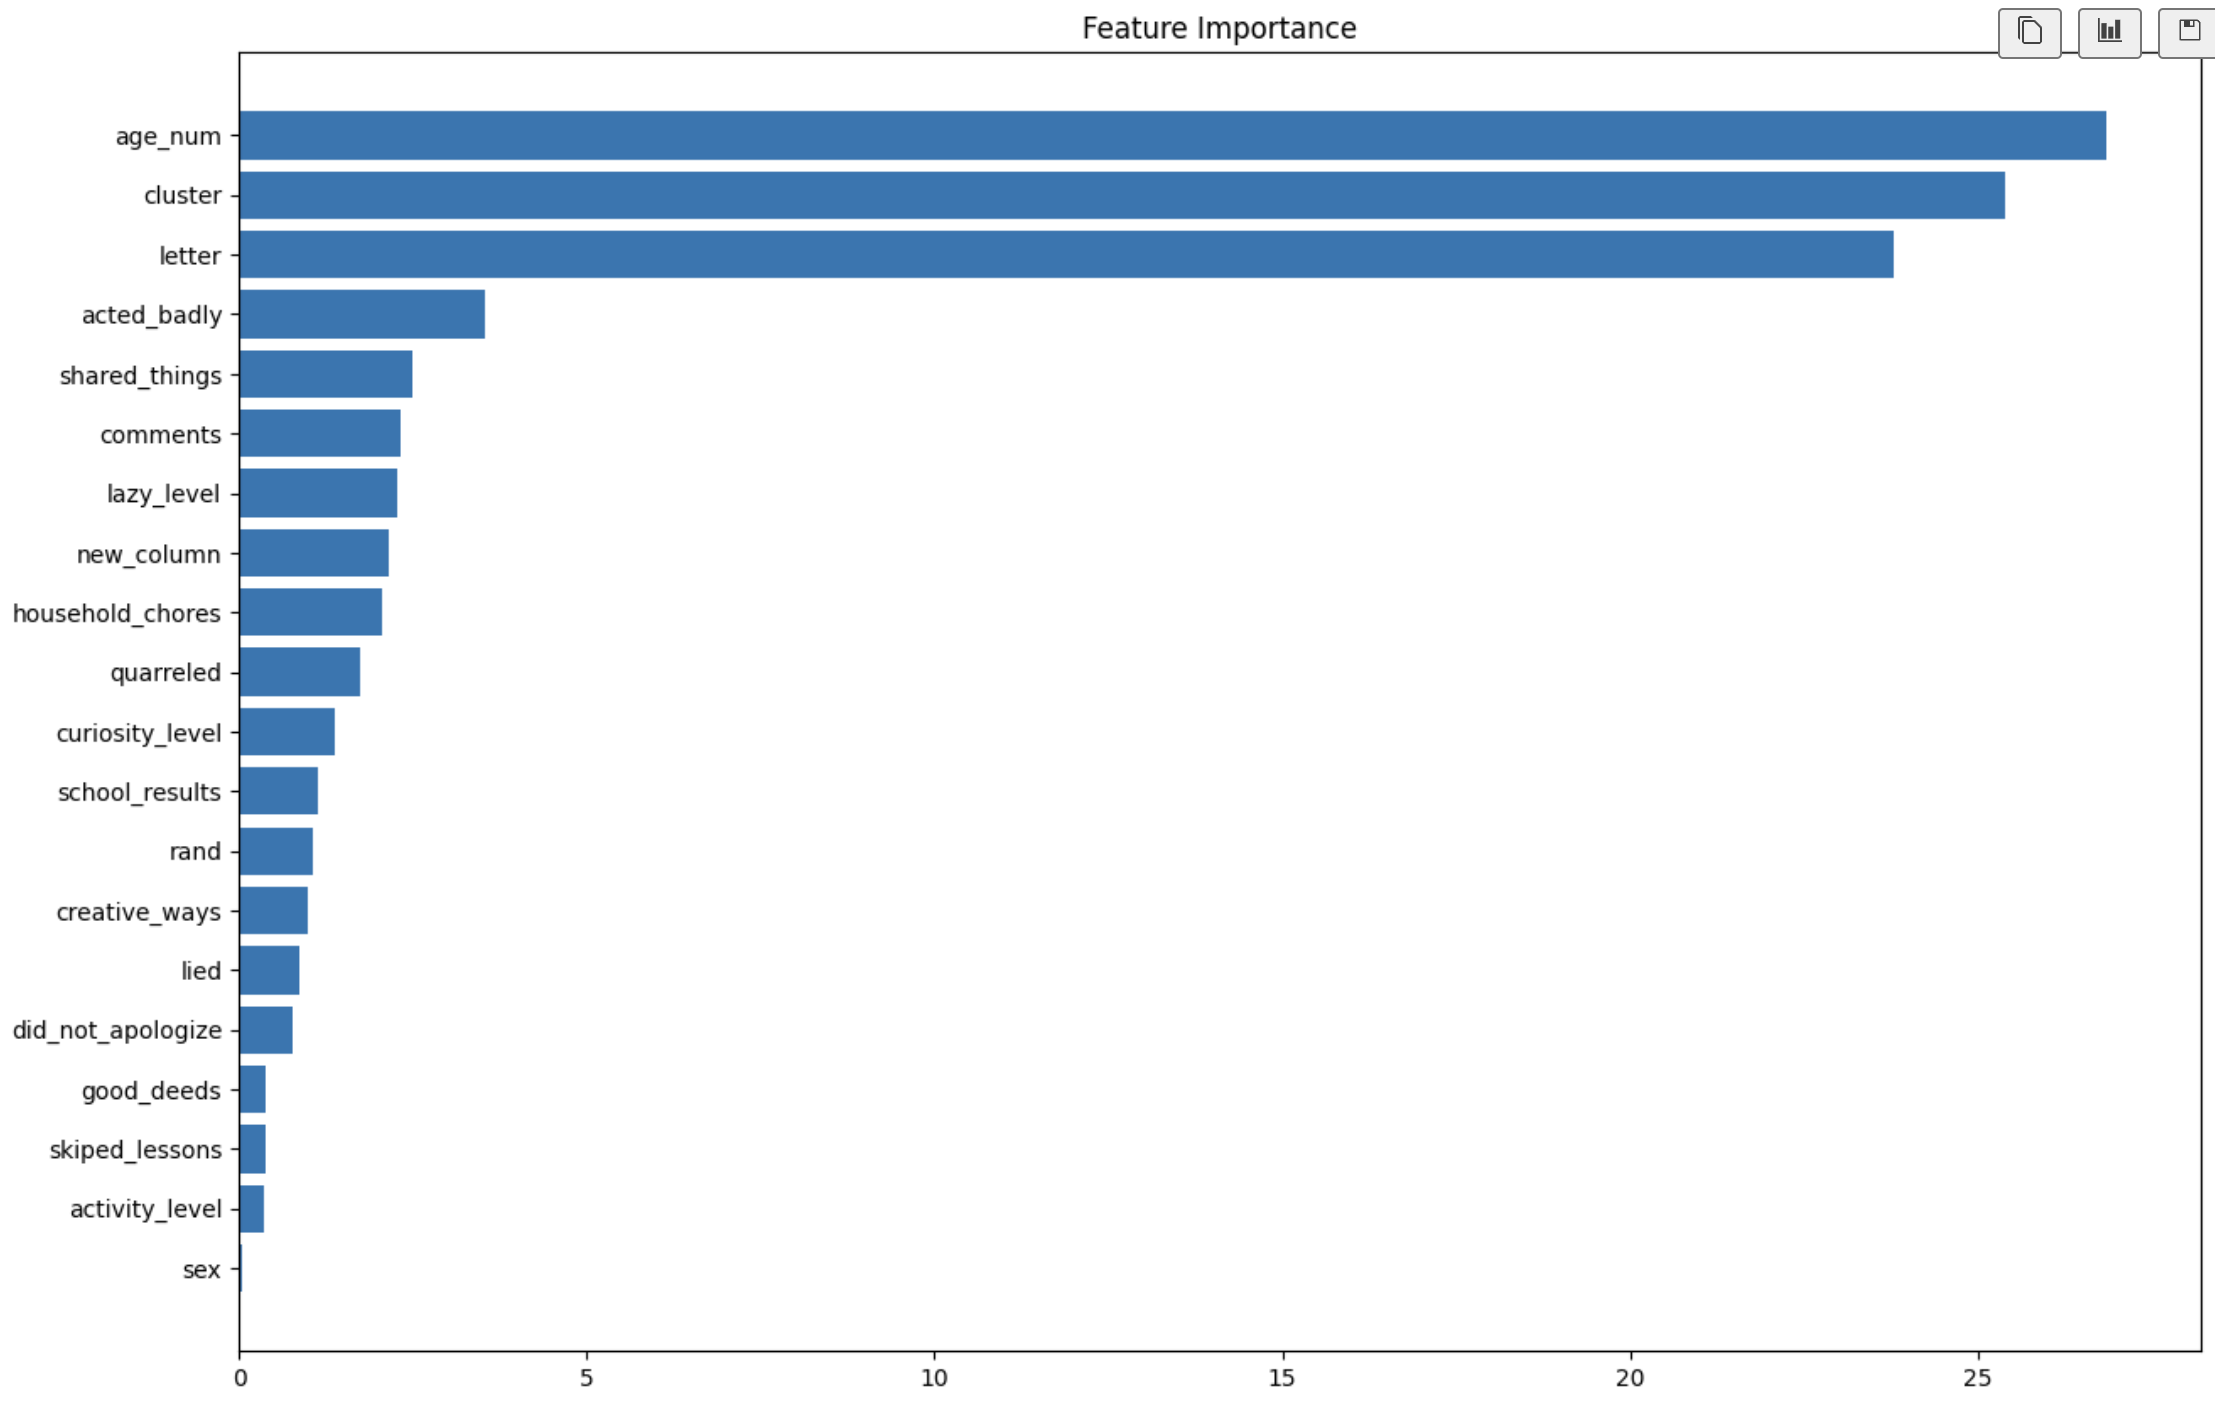

In [22]:
df.drop(columns=['sex', 'activity_level', 'skiped_lessons', 'good_deeds'], inplace=True)

In [23]:
df.head()

,person,age_num,household_chores,shared_things,quarreled,lied,acted_badly,did_not_apologize,school_results,lazy_level,creative_ways,curiosity_level,comments,letter,gift_receiving,new_let,age_cluster
0,269178,5.22,22,3.0,2.0,1965.0,36.0,12.0,Превосходно,Лентяй,91.0,59.0,"Проявил доброту, помогая близким — это похвально!",,1,0,0
1,269179,9.47,5,7.0,4.0,1936.0,35.0,5.0,Хорошо,Часто откладывает,40.0,34.0,NaN,Уважаемый Дедушка Мороз! \nУ меня в школе все ...,1,1,2
2,269180,6.35,10,6.0,4.0,1668.0,37.0,20.0,Ниже среднего,Лентяй,92.0,4.0,NaN,,1,0,0
3,269181,8.04,42,1.0,3.0,1761.0,58.0,16.0,Удовлетворительно,Лентяй,69.0,31.0,Помог бабушке перейти дорогу — это очень благо...,"Дедушка! \nПишет тебе Ростислав, мне 8 лет. \n...",1,1,2
4,269182,7.38,53,10.0,2.0,794.0,96.0,7.0,Превосходно,Часто откладывает,35.0,97.0,Иногда не может сдержать свои эмоции во время ...,,0,0,0


In [24]:
le_cols = ['school_results', 'lazy_level']

In [25]:
from sklearn.preprocessing import LabelEncoder

le_school_results = LabelEncoder()
le_lazy_level = LabelEncoder()

for i in tqdm(le_cols):
    if i == 'school_results': df[i] = le_school_results.fit_transform(df[i])
    if i == 'lazy_level': df[i] = le_lazy_level.fit_transform(df[i])

  0%|          | 0/2 [00:00<?, ?it/s]

interval columns not set, guessing: ['age_num', 'household_chores', 'shared_things', 'quarreled', 'acted_badly', 'did_not_apologize', 'school_results', 'lazy_level', 'creative_ways', 'curiosity_level', 'gift_receiving', 'new_let', 'age_cluster']


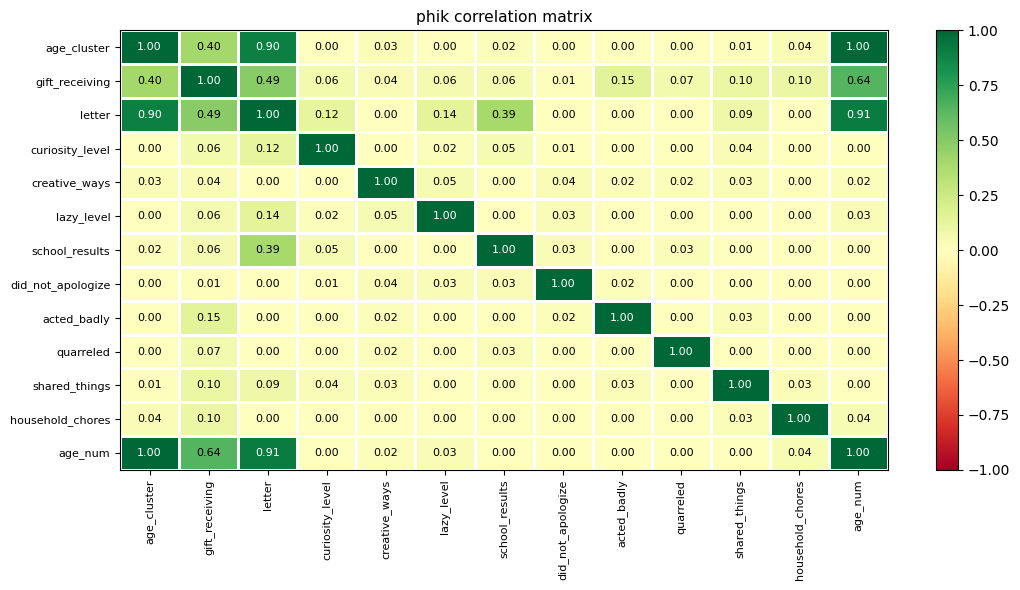

In [30]:
phik_matrix = df.drop(columns=['person']).phik_matrix()

plot_correlation_matrix(phik_matrix.values,
                        x_labels = phik_matrix.columns,
                        y_labels = phik_matrix.index,
                        title = 'phik correlation matrix',
                        fontsize_factor=0.8, figsize=(11, 6)
)

In [27]:
df.drop(columns=['comments', 'lied'], inplace=True)

# create training data

In [26]:
X = df.drop(columns = ['gift_receiving', 'person'])
X

,age_num,household_chores,shared_things,quarreled,lied,acted_badly,did_not_apologize,school_results,lazy_level,creative_ways,curiosity_level,comments,letter,cluster,new_let,new_com
0,5.22,22,3.0,2.0,1965.0,36.0,12.0,4,0,91.0,59.0,"Проявил доброту, помогая близким — это похвально!",,2.0,0,1
1,9.47,5,7.0,4.0,1936.0,35.0,5.0,6,4,40.0,34.0,,Уважаемый Дедушка Мороз! \nУ меня в школе все ...,3.0,1,0
2,6.35,10,6.0,4.0,1668.0,37.0,20.0,2,0,92.0,4.0,,,2.0,0,0
3,8.04,42,1.0,3.0,1761.0,58.0,16.0,5,0,69.0,31.0,Помог бабушке перейти дорогу — это очень благо...,"Дедушка! \nПишет тебе Ростислав, мне 8 лет. \n...",2.0,1,1
4,7.38,53,10.0,2.0,794.0,96.0,7.0,4,4,35.0,97.0,Иногда не может сдержать свои эмоции во время ...,,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,8.37,39,10.0,3.0,18.0,24.0,6.0,3,4,63.0,55.0,,"Дед! \nЯ рад, что наступила зима и твой праздн...",4.0,1,0
7996,9.78,19,9.0,4.0,518.0,79.0,8.0,4,2,43.0,14.0,,"Дорогой Санта! \nПишет тебе Юлиан, мне 9 лет. ...",2.0,1,0
7997,11.69,15,3.0,4.0,1703.0,82.0,14.0,0,2,48.0,33.0,"Было замечено, что пропустил важный урок без п...","Здравствуйте, Дедушка. \nПишет тебе Альберт, м...",3.0,1,1
7998,6.27,10,0.0,0.0,943.0,71.0,14.0,2,1,68.0,1.0,,,0.0,0,0


In [27]:
y = df.gift_receiving
y

0       1
1       1
2       1
3       1
4       0
       ..
7995    1
7996    0
7997    0
7998    1
7999    1
Name: gift_receiving, Length: 8000, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1001, stratify=y)

# optuna + catboost

In [28]:
# # Функция для оценки модели с заданными гиперпараметрами
# def objective(trial):
#     # Определение пространства поиска гиперпараметров
#     # params = {
#     #     'iterations': trial.suggest_int('iterations', 100, 3000),
#     #     'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#     #     'depth': trial.suggest_int('depth', 2, 10),
#     #     'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),
#     #     'border_count': trial.suggest_int('border_count', 32, 255),
#     #     # 'random_strength': trial.suggest_uniform('random_strength', 0.5, 50),
#     #     # 'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),
#     #     # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
#     #     # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
#     #     # 'max_leaves': trial.suggest_int('max_leaves', 2, 64) if params['grow_policy'] == 'Lossguide' else None,
#     #     # 'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
#     #     'task_type': 'CPU',  # Или 'GPU', если вы хотите использовать GPU
#     #     'verbose': 0,
#     #     'random_seed': 1001
#     # }

#     params = {
#         "iterations": trial.suggest_int('iterations', 100, 3000),
#         # "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'text_features':['letter', 'comments'],
#         "depth": trial.suggest_int("depth", 1, 10),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),
#         "subsample": trial.suggest_float("subsample", 0.05, 1.0),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#         'task_type': 'CPU',  # Или 'GPU', если вы хотите использовать GPU
#         'verbose': 0,
#         'random_seed': 1001
#     }

#     # Создание и обучение модели
#     model = CatBoostClassifier(**params)
#     model.fit(X_train, y_train)
    
#     # Определите макро F1-score как scorer
#     # macro_f1_scorer = make_scorer(f1_score, average='macro')

#     # Используйте cross_val_score с макро F1-score
#     # scores = cross_val_score(model, X_train, y_train, cv=5, scoring=macro_f1_scorer)
#     scores = f1_score(y_test, model.predict(X_test), average='macro')
    
#     # Возвращаем среднее значение метрики (accuracy) для кросс-валидации
#     return scores
#     # return scores.mean()

In [29]:
# # Создание объекта исследования
# study = optuna.create_study(direction='maximize')

In [30]:
# # Запуск оптимизации
# study.optimize(objective, n_trials=3)

In [31]:
# df = study.trials_dataframe()
# best_trials_df = df.sort_values('value', ascending=False).head(3)
# best_trials_df

In [32]:
# best_trials = sorted(study.trials, key=lambda trial: trial.value, reverse=True)[:3]
# best_trials

In [33]:
# X_train['rand'] = np.random.rand(7200)
# X_test['rand'] = np.random.rand(800)

In [53]:
model = CatBoostClassifier(# text_features=['letter', 'comments'],
                            text_features=['letter'],
                            task_type='CPU',
                            random_seed=1001,  
                            verbose=52)
model.fit(X_train, y_train)

Learning rate set to 0.023934
0:	learn: 0.6839757	total: 67.4ms	remaining: 1m 7s
52:	learn: 0.4858806	total: 3.23s	remaining: 57.6s
104:	learn: 0.4461123	total: 6.09s	remaining: 52s
156:	learn: 0.4256286	total: 8.89s	remaining: 47.7s
208:	learn: 0.4104323	total: 11.6s	remaining: 43.9s
260:	learn: 0.4002418	total: 14.4s	remaining: 40.7s
312:	learn: 0.3889430	total: 17.2s	remaining: 37.6s
364:	learn: 0.3792542	total: 19.8s	remaining: 34.5s
416:	learn: 0.3674404	total: 22.8s	remaining: 31.8s
468:	learn: 0.3542110	total: 25.5s	remaining: 28.9s
520:	learn: 0.3427460	total: 28.4s	remaining: 26.1s
572:	learn: 0.3331178	total: 31.3s	remaining: 23.4s
624:	learn: 0.3242219	total: 34.3s	remaining: 20.6s
676:	learn: 0.3159060	total: 37.3s	remaining: 17.8s
728:	learn: 0.3089533	total: 40.2s	remaining: 14.9s
780:	learn: 0.3018299	total: 43.1s	remaining: 12.1s
832:	learn: 0.2956068	total: 46s	remaining: 9.22s
884:	learn: 0.2891515	total: 48.9s	remaining: 6.35s
936:	learn: 0.2833279	total: 51.8s	remai

Text(0.5, 1.0, 'Feature Importance')

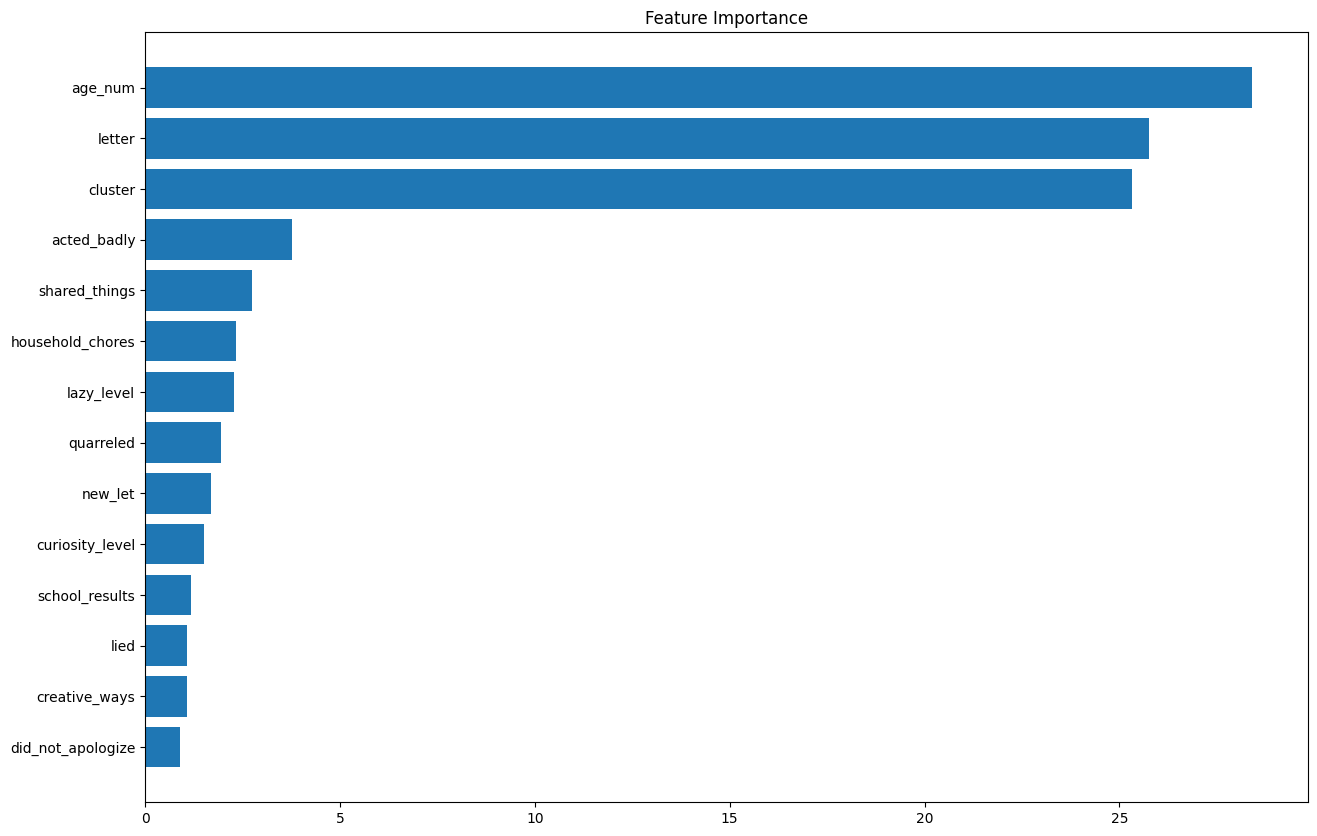

In [54]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [36]:
# best_params = study.best_params
# best_model = CatBoostClassifier(**best_params,
#                             text_features=['letter', 'comments'],
#                             task_type='CPU',
#                             random_seed=1001,  
#                             verbose=52)
# best_model.fit(X_train, y_train)

In [55]:
predictions = model.predict(X_test)
f1_score(y_test, predictions, average='macro')

0.8432088254616324

# predict

In [56]:
pred_df = pd.read_csv('test.csv')
pred_df.head(3)

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,did_not_apologize,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing
0,277178,9.61,Девочка,20,6.0,23,4.0,1165.0,6.0,30.0,13.0,Отлично,Редкий гость,Редко откладывает,59.0,56.0,NaN,NaN,B2VANIROYC.jpg
1,277179,12.33,Девочка,20,6.0,22,2.0,1762.0,1.0,49.0,17.0,Отлично,Редкий гость,Средний уровень,81.0,54.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я нич...",X10WFLD6Z8.jpg
2,277180,7.20,Мальчик,22,1.0,13,4.0,478.0,4.0,71.0,5.0,Отлично,Непостоянный энтузиаст,Средний уровень,6.0,14.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я был...",J1YN5FZBXK.jpg


In [57]:
img_df = pred_df[['drawing']]
img_df.dropna(inplace=True)
img_df

,drawing
0,B2VANIROYC.jpg
1,X10WFLD6Z8.jpg
2,J1YN5FZBXK.jpg
3,NKDHA7OXZ4.jpg
4,DR0HNPE527.jpg
...,...
1994,PUNJOV9YLX.jpg
1995,I5AGBU3C81.jpg
1996,G805MCOJWQ.jpg
1997,J3YTL9REAH.jpg


In [58]:
img_df['images'] = img_df['drawing'].progress_apply(read_image)

  0%|          | 0/1851 [00:00<?, ?it/s]

In [59]:
images = np.array([img.flatten() for img in tqdm(img_df['images'])])
# images = pca.transform(np.array([img.flatten() for img in img_df['images']]))

  0%|          | 0/1851 [00:00<?, ?it/s]

In [60]:
kmeans.predict(images)

array([3, 4, 3, ..., 4, 4, 4])

In [61]:
img_df['cluster'] = kmeans.predict(images)
img_df.drop(columns=['images'], inplace=True)
img_df

,drawing,cluster
0,B2VANIROYC.jpg,3
1,X10WFLD6Z8.jpg,4
2,J1YN5FZBXK.jpg,3
3,NKDHA7OXZ4.jpg,2
4,DR0HNPE527.jpg,2
...,...,...
1994,PUNJOV9YLX.jpg,3
1995,I5AGBU3C81.jpg,3
1996,G805MCOJWQ.jpg,4
1997,J3YTL9REAH.jpg,4


In [62]:
Counter(img_df['cluster'])

Counter({3: 635, 2: 557, 4: 360, 0: 168, 1: 131})

In [63]:
pred_df = pd.merge(pred_df, img_df, on='drawing', how='left')
pred_df

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,did_not_apologize,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing,cluster
0,277178,9.61,Девочка,20,6.0,23,4.0,1165.0,6.0,30.0,13.0,Отлично,Редкий гость,Редко откладывает,59.0,56.0,NaN,NaN,B2VANIROYC.jpg,3.0
1,277179,12.33,Девочка,20,6.0,22,2.0,1762.0,1.0,49.0,17.0,Отлично,Редкий гость,Средний уровень,81.0,54.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я нич...",X10WFLD6Z8.jpg,4.0
2,277180,7.20,Мальчик,22,1.0,13,4.0,478.0,4.0,71.0,5.0,Отлично,Непостоянный энтузиаст,Средний уровень,6.0,14.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я был...",J1YN5FZBXK.jpg,3.0
3,277181,6.95,Девочка,33,7.0,16,2.0,618.0,3.0,42.0,11.0,Удовлетворительно,Активный участник,Средний уровень,89.0,50.0,NaN,NaN,NKDHA7OXZ4.jpg,2.0
4,277182,5.72,Мальчик,44,1.0,16,5.0,1798.0,2.0,25.0,7.0,Хорошо,Редкий гость,Часто откладывает,89.0,89.0,NaN,NaN,DR0HNPE527.jpg,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,279173,14.03,Девочка,44,1.0,28,0.0,1897.0,6.0,70.0,2.0,Отлично,Непостоянный энтузиаст,Лентяй,55.0,39.0,"Иногда проявляет лень, откладывая дела на пото...","Дорогой Санта Клаус! \nПишет тебе Вика, мне 14...",I5AGBU3C81.jpg,3.0
1996,279174,5.85,Мальчик,17,2.0,12,1.0,1980.0,1.0,94.0,12.0,Хорошо,Редкий гость,Средний уровень,18.0,71.0,"Иногда не приходит на занятия, что может повли...",NaN,G805MCOJWQ.jpg,4.0
1997,279175,9.68,Мальчик,47,9.0,17,1.0,351.0,5.0,45.0,9.0,Ниже среднего,Активный участник,Часто откладывает,54.0,42.0,NaN,"Уважаемый Дедушка Мороз! \nПишет тебе Альберт,...",J3YTL9REAH.jpg,4.0
1998,279176,7.83,Мальчик,18,6.0,23,3.0,95.0,2.0,81.0,10.0,Превосходно,Редкий гость,Часто откладывает,97.0,41.0,NaN,"Привет, Дедушка! \nПишет тебе Тихон, мне 7 лет...",NaN,NaN


In [64]:
pred_df['new_let'] = pred_df['letter'].notnull().astype(int)
# pred_df['new_com'] = pred_df['comments'].notnull().astype(int)
pred_df

,person,age_num,sex,household_chores,shared_things,good_deeds,quarreled,lied,skiped_lessons,acted_badly,...,school_results,activity_level,lazy_level,creative_ways,curiosity_level,comments,letter,drawing,cluster,new_let
0,277178,9.61,Девочка,20,6.0,23,4.0,1165.0,6.0,30.0,...,Отлично,Редкий гость,Редко откладывает,59.0,56.0,NaN,NaN,B2VANIROYC.jpg,3.0,0
1,277179,12.33,Девочка,20,6.0,22,2.0,1762.0,1.0,49.0,...,Отлично,Редкий гость,Средний уровень,81.0,54.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я нич...",X10WFLD6Z8.jpg,4.0,1
2,277180,7.20,Мальчик,22,1.0,13,4.0,478.0,4.0,71.0,...,Отлично,Непостоянный энтузиаст,Средний уровень,6.0,14.0,NaN,"Здравствуйте, Санта Клаус. \nВ этом году я был...",J1YN5FZBXK.jpg,3.0,1
3,277181,6.95,Девочка,33,7.0,16,2.0,618.0,3.0,42.0,...,Удовлетворительно,Активный участник,Средний уровень,89.0,50.0,NaN,NaN,NKDHA7OXZ4.jpg,2.0,0
4,277182,5.72,Мальчик,44,1.0,16,5.0,1798.0,2.0,25.0,...,Хорошо,Редкий гость,Часто откладывает,89.0,89.0,NaN,NaN,DR0HNPE527.jpg,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,279173,14.03,Девочка,44,1.0,28,0.0,1897.0,6.0,70.0,...,Отлично,Непостоянный энтузиаст,Лентяй,55.0,39.0,"Иногда проявляет лень, откладывая дела на пото...","Дорогой Санта Клаус! \nПишет тебе Вика, мне 14...",I5AGBU3C81.jpg,3.0,1
1996,279174,5.85,Мальчик,17,2.0,12,1.0,1980.0,1.0,94.0,...,Хорошо,Редкий гость,Средний уровень,18.0,71.0,"Иногда не приходит на занятия, что может повли...",NaN,G805MCOJWQ.jpg,4.0,0
1997,279175,9.68,Мальчик,47,9.0,17,1.0,351.0,5.0,45.0,...,Ниже среднего,Активный участник,Часто откладывает,54.0,42.0,NaN,"Уважаемый Дедушка Мороз! \nПишет тебе Альберт,...",J3YTL9REAH.jpg,4.0,1
1998,279176,7.83,Мальчик,18,6.0,23,3.0,95.0,2.0,81.0,...,Превосходно,Редкий гость,Часто откладывает,97.0,41.0,NaN,"Привет, Дедушка! \nПишет тебе Тихон, мне 7 лет...",NaN,NaN,1


In [65]:
pred_df.drop(columns=['drawing'], inplace=True)
pred_df.fillna('', inplace=True)
pred_df.isna().sum()

person               0
age_num              0
sex                  0
household_chores     0
shared_things        0
good_deeds           0
quarreled            0
lied                 0
skiped_lessons       0
acted_badly          0
did_not_apologize    0
school_results       0
activity_level       0
lazy_level           0
creative_ways        0
curiosity_level      0
comments             0
letter               0
cluster              0
new_let              0
dtype: int64

In [66]:
pred_df.drop(columns=['person', 'sex', 'activity_level', 'skiped_lessons', 'good_deeds'], inplace=True)

In [67]:
pred_df.drop(columns=['comments'], inplace=True)

In [68]:
for i in tqdm(le_cols):
    if i == 'school_results': pred_df[i] = le_school_results.fit_transform(pred_df[i])
    if i == 'lazy_level': pred_df[i] = le_lazy_level.fit_transform(pred_df[i])

  0%|          | 0/2 [00:00<?, ?it/s]

In [69]:
pred_df.fillna('', inplace=True)

In [70]:
sample = pd.read_csv('sample_submission.csv')
sample

,person,gift_receiving
0,277178,0
1,277179,0
2,277180,0
3,277181,0
4,277182,0
...,...,...
1995,279173,0
1996,279174,0
1997,279175,0
1998,279176,0


In [71]:
# pred_df['rand'] = np.random.rand(len(pred_df))

In [72]:
# predictions = ensemble_model_voting.predict(pred_df)
predictions = model.predict(pred_df)
sample['gift_receiving'] = predictions
Counter(sample['gift_receiving'])

Counter({0: 1080, 1: 920})

In [73]:
sample.to_csv('sub.csv', index=False)